In [162]:
from tempfile import TemporaryDirectory
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision import models
import os
from PIL import Image
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
train_set = pd.read_csv("Training_set.csv")
test_set = pd.read_csv("Testing_set.csv")
classes = train_set.label.unique()

In [120]:
class ButterfliesDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df
        self.path = path
        self.transform = transform
        self.classes = sorted(classes)
        self.classes_index = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.df.iloc[idx]['filename'])
        image = Image.open(img_path)
        label = self.classes_index[self.df.iloc[idx]['label']]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [121]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 150)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    # transforms.RandomAffine(degrees=5, translate=(0.03, 0.03), scale=(0.95, 1.05)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 150)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [122]:
train_img_df = ButterfliesDataset(train_set, "train", transform_train)
val_img_df = ButterfliesDataset(train_set, "train", transform_test)
test_img_df = ButterfliesDataset(test_set, "test", transform_test)

In [123]:
train_size = int(len(train_img_df) * 0.8)
val_size = len(train_img_df) - train_size
train_indices, val_indices = random_split(range(len(train_img_df)), [train_size, val_size])

In [124]:
train_subset = torch.utils.data.Subset(train_img_df, train_indices)
val_subset = torch.utils.data.Subset(val_img_df, val_indices)

In [125]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_img_df, batch_size=32, shuffle=False)

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [127]:
def train_one(model, loss_fn, train_loader, optimizer, device):
    total_loss = 0
    all_preds = []
    all_labels = []
    correct = 0
    total_acc = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total_acc
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, accuracy, f1

In [128]:
def validate(model, loss_fn, val_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            total += labels.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * correct / total
    avg_loss = total_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, acc, f1

In [129]:
def train_model(model, loss_fn, train_loader, val_loader, optimizer, scheduler, num_epochs):
    with TemporaryDirectory() as tempdir:
        model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), model_params_path)
        best_acc = 0.0
        history = []
        
        for epoch in range(num_epochs):
            train_loss, train_acc, train_f1 = train_one(model, loss_fn, train_loader, optimizer, device)
            scheduler.step()
            val_loss, val_acc, val_f1 = validate(model, loss_fn, val_loader, device)
            
            history.append([train_acc, val_acc, train_loss, val_loss, train_f1, val_f1])
            print(f'Epoch {epoch+1}/{num_epochs}: '
                  f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1}, '
                  f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1}')
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_params_path)
        print(f"Best validation accuracy: {best_acc:.4f}")
        model.load_state_dict(torch.load(model_params_path))
    return model, history

In [154]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(num_ftrs, 75)
model.to(device)

C:\Users\Surface\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Surface\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [155]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
step_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [156]:
def unfreeze(model, layers):
   for name, param in model.named_parameters():
        if any(layer in name for layer in layers):
            param.requires_grad = True

In [157]:
def get_optimizer(model, lr):
    return optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

In [158]:
def get_transform(level='none'):
    base = [
        transforms.ToTensor(),
        transforms.Resize((150, 150)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
    light = base + [
        transforms.RandomHorizontalFlip(p=0.5),
    ]
    medium = base + [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(10),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1)
    ]
    strong = base + [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomAffine(degrees=5, translate=(0.03, 0.03), scale=(0.95, 1.05)),
    ]

    presets = {
        'none': transforms.Compose(base),
        'light': transforms.Compose(light),
        'medium': transforms.Compose(medium),
        'strong': transforms.Compose(strong),
    }
    return presets[level]

In [159]:
stages = [
    {'layers': ['fc'], 'lr': 1e-3, 'epochs': 7, 'aug': 'none'},
    {'layers': ['fc', 'layer4'], 'lr': 1e-4, 'epochs': 5, 'aug': 'light'},
    {'layers': ['fc', 'layer4', 'layer3'], 'lr': 1e-5, 'epochs': 3, 'aug': 'medium'},
    {'layers': ['fc', 'layer4', 'layer3', 'layer2'], 'lr': 5e-6, 'epochs': 3, 'aug': 'medium'},
]

In [160]:
def run_finetuning_pipeline(model, loss_fn, stages):
    history_total = []

    for i, stage in enumerate(stages):
        print(f"\nStage {i+1}: Layers {stage['layers']}, lr={stage['lr']}, aug={stage['aug']}")

        unfreeze(model, stage['layers'])
        optimizer = get_optimizer(model, lr=stage['lr'])
        scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

        transform_train = get_transform(stage['aug'])
        transform_test = get_transform('none')

        train_dataset = ButterfliesDataset(train_set, "train", transform_train)
        val_dataset = ButterfliesDataset(train_set, "train", transform_test)

        train_indices, val_indices = random_split(range(len(train_dataset)), [int(0.8 * len(train_dataset)), len(train_dataset) - int(0.8 * len(train_dataset))])
        train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, train_indices), batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(val_dataset, val_indices), batch_size=32, shuffle=False)

        model, history = train_model(model, loss_fn, train_loader, val_loader, optimizer, scheduler, stage['epochs'])
        history_total.extend(history)

    return model, history_total

In [161]:
model, full_history = run_finetuning_pipeline(model, loss_fn, stages)


Stage 1: Layers ['fc'], lr=0.001, aug=none


100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


Epoch 1/7: Train Loss: 2.5235, Acc: 47.8746, F1: 0.47362992466199216, Val Loss: 1.2861, Acc: 75.5385, F1: 0.7440592059289157


100%|██████████| 41/41 [00:28<00:00,  1.43it/s]


Epoch 2/7: Train Loss: 0.8922, Acc: 82.1504, F1: 0.820850365257883, Val Loss: 0.8835, Acc: 80.6923, F1: 0.7981719328973328


100%|██████████| 41/41 [00:27<00:00,  1.48it/s]


Epoch 3/7: Train Loss: 0.5747, Acc: 89.3441, F1: 0.8931022863126592, Val Loss: 0.7875, Acc: 82.4615, F1: 0.8157986723758313


100%|██████████| 41/41 [00:24<00:00,  1.69it/s]


Epoch 4/7: Train Loss: 0.4787, Acc: 91.3637, F1: 0.9129826722295993, Val Loss: 0.7466, Acc: 82.5385, F1: 0.8215478242401079


100%|██████████| 41/41 [00:24<00:00,  1.69it/s]


Epoch 5/7: Train Loss: 0.4037, Acc: 93.4987, F1: 0.9349192520330265, Val Loss: 0.6909, Acc: 84.3846, F1: 0.8384147793434986


100%|██████████| 41/41 [00:24<00:00,  1.68it/s]


Epoch 6/7: Train Loss: 0.3716, Acc: 93.8834, F1: 0.9385542227001021, Val Loss: 0.6827, Acc: 84.4615, F1: 0.842510536486437


100%|██████████| 41/41 [00:24<00:00,  1.68it/s]


Epoch 7/7: Train Loss: 0.3404, Acc: 95.1144, F1: 0.9510708660704494, Val Loss: 0.6696, Acc: 84.5385, F1: 0.8416299839039988
Best validation accuracy: 84.5385

Stage 2: Layers ['fc', 'layer4'], lr=0.0001, aug=light


100%|██████████| 41/41 [00:24<00:00,  1.67it/s]


Epoch 1/5: Train Loss: 0.4583, Acc: 86.6705, F1: 0.8659273346352302, Val Loss: 0.3959, Acc: 87.5385, F1: 0.8721461738370122


100%|██████████| 41/41 [00:24<00:00,  1.64it/s]


Epoch 2/5: Train Loss: 0.1727, Acc: 94.4412, F1: 0.9438446887446743, Val Loss: 0.3466, Acc: 90.6923, F1: 0.9066982170950159


100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 3/5: Train Loss: 0.0531, Acc: 98.3074, F1: 0.9829216278966431, Val Loss: 0.2986, Acc: 91.6923, F1: 0.91613645708794


100%|██████████| 41/41 [00:26<00:00,  1.54it/s]


Epoch 4/5: Train Loss: 0.0276, Acc: 99.0190, F1: 0.9902777600832201, Val Loss: 0.3114, Acc: 92.0769, F1: 0.9215700995314798


100%|██████████| 41/41 [00:26<00:00,  1.54it/s]


Epoch 5/5: Train Loss: 0.0214, Acc: 99.4230, F1: 0.9942648719612178, Val Loss: 0.2925, Acc: 93.2308, F1: 0.9328146429758357
Best validation accuracy: 93.2308

Stage 3: Layers ['fc', 'layer4', 'layer3'], lr=1e-05, aug=medium


100%|██████████| 41/41 [00:30<00:00,  1.36it/s]


Epoch 1/3: Train Loss: 0.3208, Acc: 90.7482, F1: 0.9059671116606052, Val Loss: 0.0884, Acc: 97.7692, F1: 0.9770307513489391


100%|██████████| 41/41 [00:27<00:00,  1.52it/s]


Epoch 2/3: Train Loss: 0.2267, Acc: 93.0948, F1: 0.9303096574475844, Val Loss: 0.0894, Acc: 97.6923, F1: 0.9756660979609039


100%|██████████| 41/41 [00:33<00:00,  1.24it/s]


Epoch 3/3: Train Loss: 0.1726, Acc: 94.7105, F1: 0.9465846056082807, Val Loss: 0.0795, Acc: 98.0769, F1: 0.9799566995197302
Best validation accuracy: 98.0769

Stage 4: Layers ['fc', 'layer4', 'layer3', 'layer2'], lr=5e-06, aug=medium


100%|██████████| 41/41 [00:26<00:00,  1.54it/s]


Epoch 1/3: Train Loss: 0.1840, Acc: 94.5374, F1: 0.9447706010188165, Val Loss: 0.0527, Acc: 98.7692, F1: 0.9868525202685705


100%|██████████| 41/41 [00:28<00:00,  1.41it/s]


Epoch 2/3: Train Loss: 0.1618, Acc: 94.9413, F1: 0.9493650407328983, Val Loss: 0.0492, Acc: 98.6923, F1: 0.9860193267752144


100%|██████████| 41/41 [00:27<00:00,  1.48it/s]

Epoch 3/3: Train Loss: 0.1420, Acc: 95.6145, F1: 0.9560413093492618, Val Loss: 0.0567, Acc: 98.6923, F1: 0.9862087460595789
Best validation accuracy: 98.7692


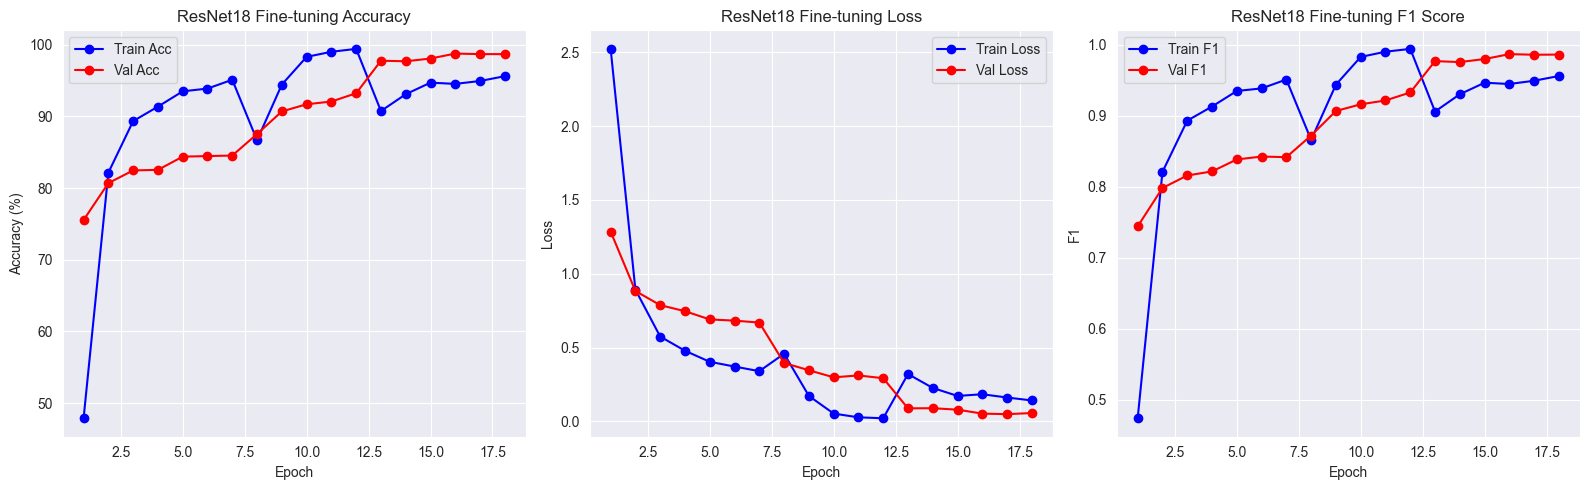

In [163]:
history = list(zip(*full_history))
train_acc, val_acc, train_loss, val_loss, train_f1, val_f1 = history

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_acc, 'bo-', label='Train Acc')
plt.plot(epochs, val_acc, 'ro-', label='Val Acc')
plt.title('ResNet18 Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_loss, 'bo-', label='Train Loss')
plt.plot(epochs, val_loss, 'ro-', label='Val Loss')
plt.title('ResNet18 Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1, 'bo-', label='Train F1')
plt.plot(epochs, val_f1, 'ro-', label='Val F1')
plt.title(f'ResNet18 Fine-tuning F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

plt.tight_layout()
plt.show()

In [164]:
def plot_confusion_matrix(y_true, y_pred, labels, group_size=15):
    num_classes = len(labels)
    num_groups = (num_classes + group_size - 1) // group_size

    for group_idx in range(num_groups):
        start = group_idx * group_size
        end = min((group_idx + 1) * group_size, num_classes)

        selected_labels = list(range(start, end))
        cm = confusion_matrix(y_true, y_pred, labels=selected_labels)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="mako",
                    xticklabels=labels[start:end], yticklabels=labels[start:end])
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title(f"Confusion Matrix (Classes {start}-{end - 1})")
        plt.tight_layout()
        plt.show()

In [165]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Collecting predictions"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

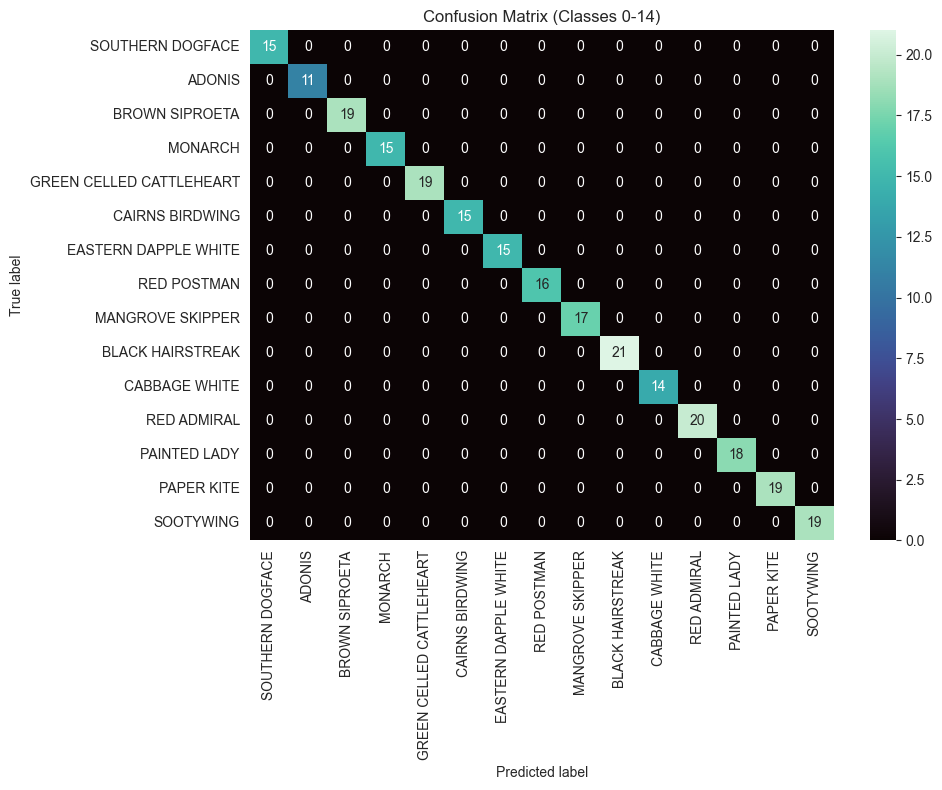

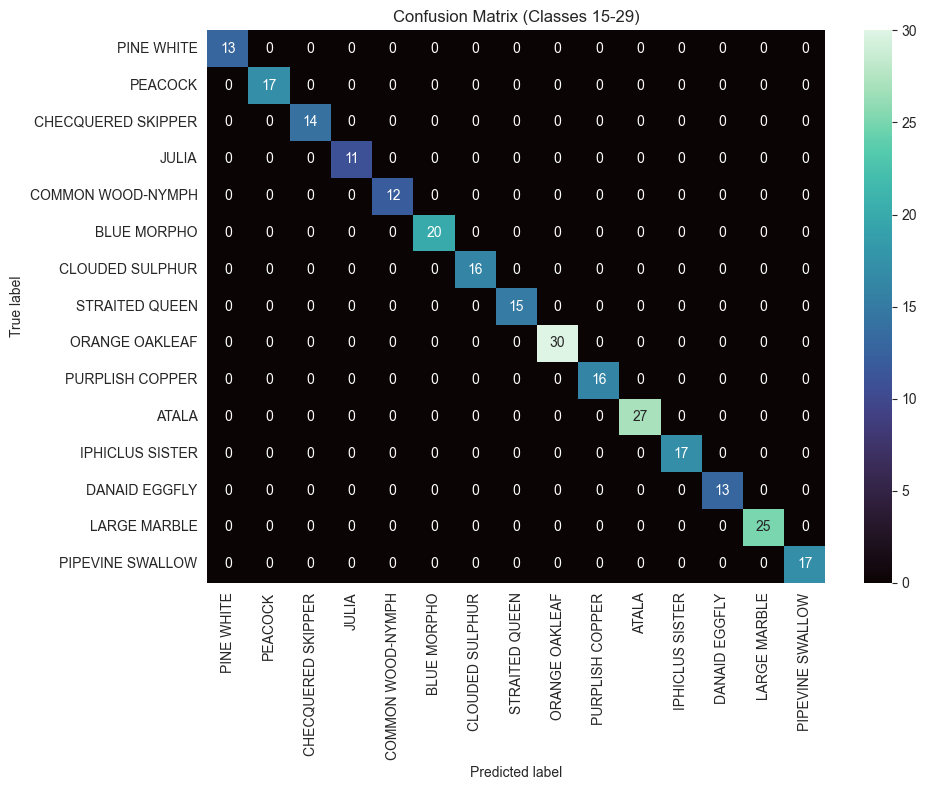

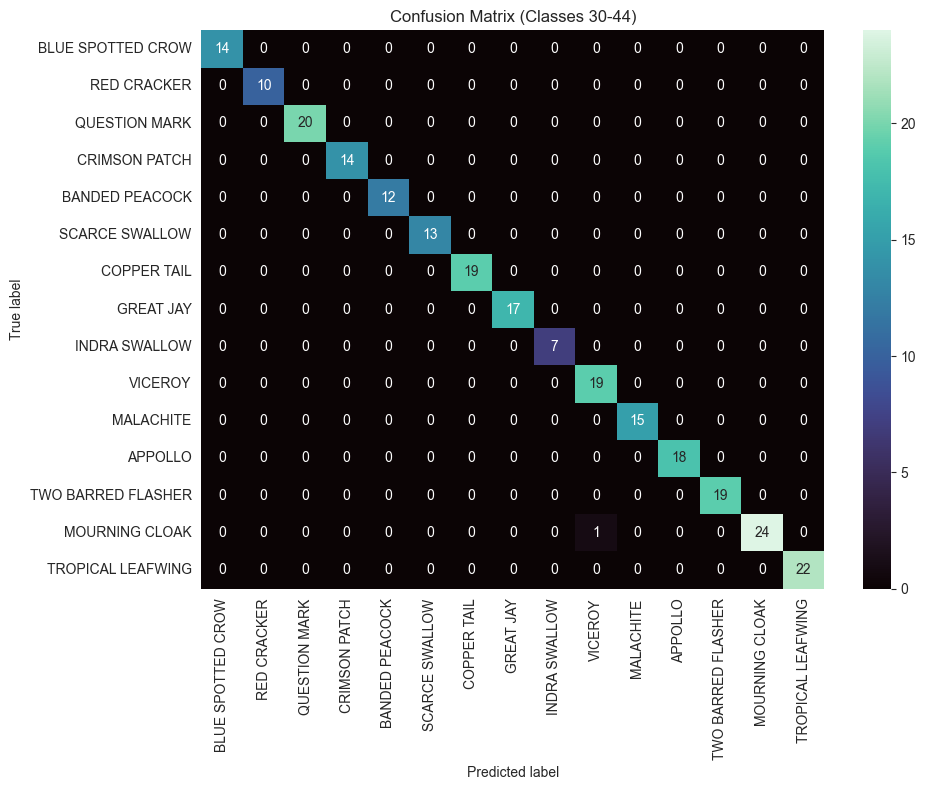

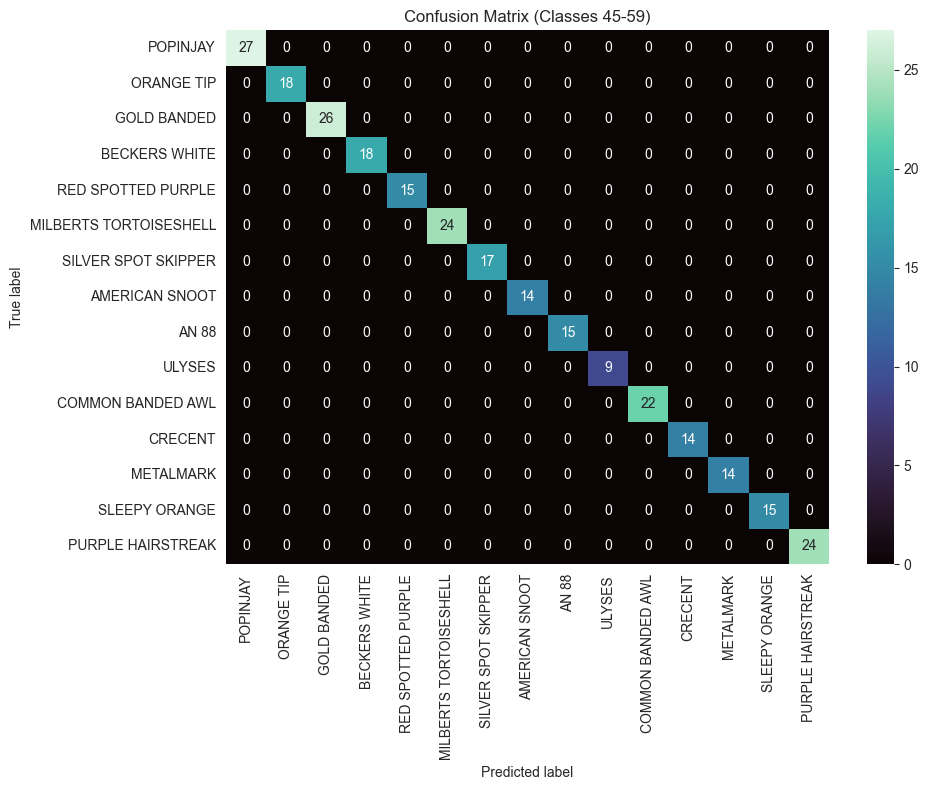

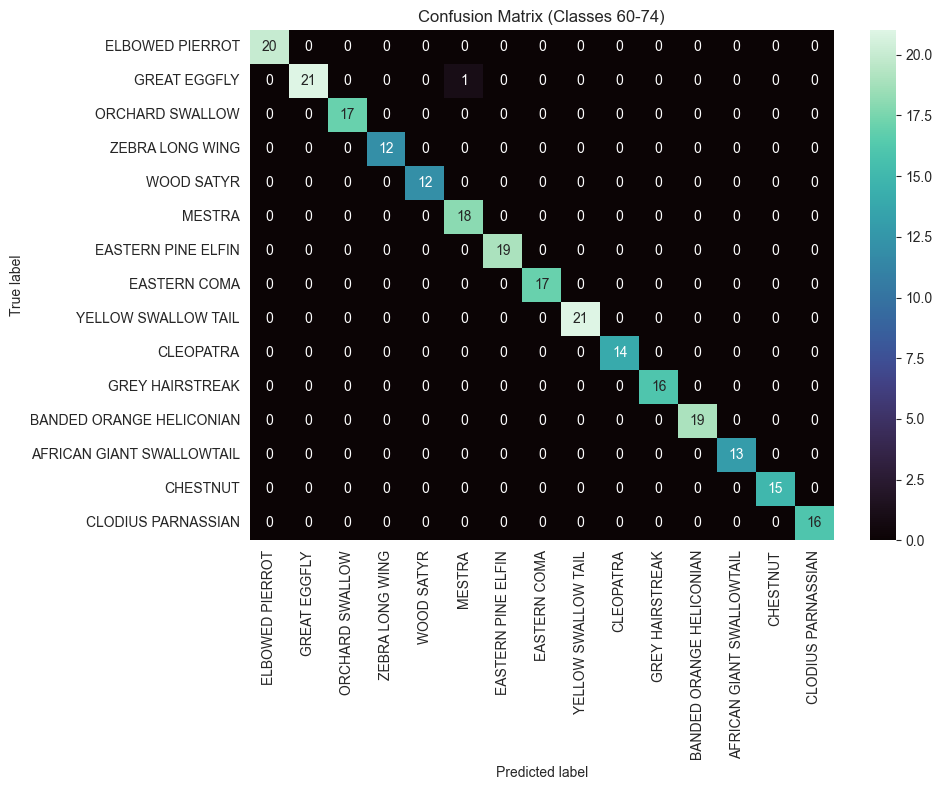

In [166]:
plot_confusion_matrix(y_true, y_pred, classes, group_size=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


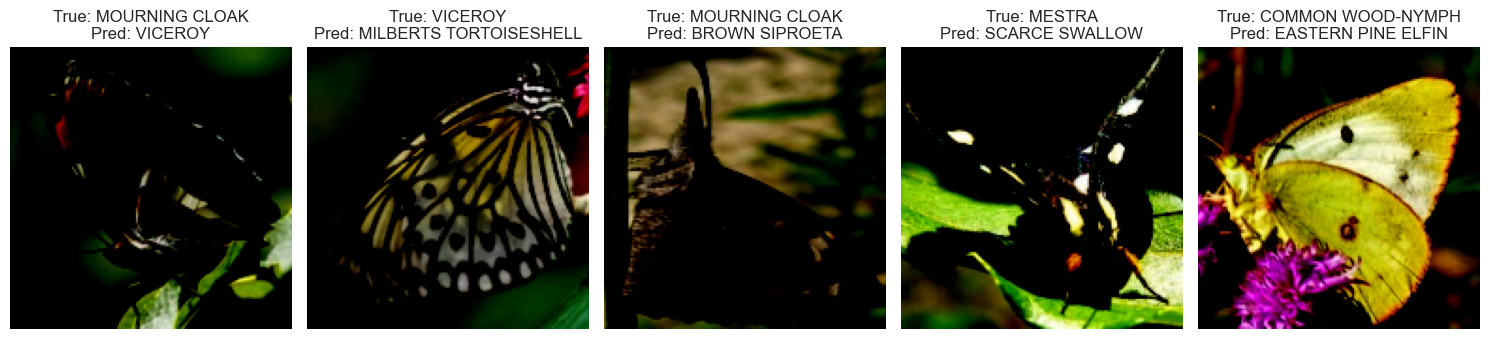

In [167]:
wrong_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]

num_to_show = 5

plt.figure(figsize=(15, 5))
shown = 0

for idx in wrong_indices:
    if shown >= num_to_show:
        break

    image, label = val_subset[idx]
    pred_label = y_pred[idx]

    plt.subplot(1, num_to_show, shown + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"True: {classes[label]}\nPred: {classes[pred_label]}")
    plt.axis('off')
    shown += 1

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


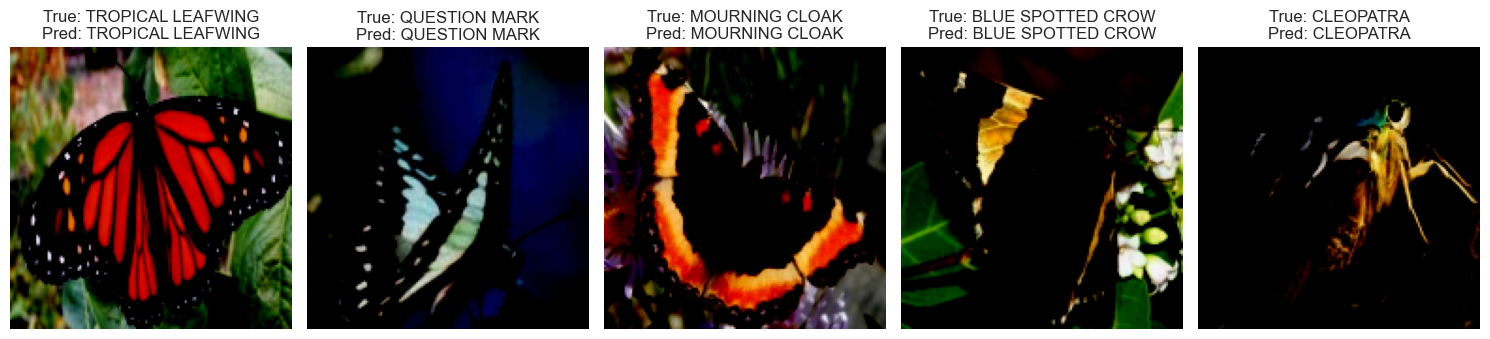

In [168]:
true_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true == pred]

num_to_show = 5

plt.figure(figsize=(15, 5))
shown = 0

for idx in true_indices:
    if shown >= num_to_show:
        break

    image, label = val_subset[idx]
    pred_label = y_pred[idx]

    plt.subplot(1, num_to_show, shown + 1)
    plt.imshow(image.permute(1, 2, 0)) 
    plt.title(f"True: {classes[label]}\nPred: {classes[pred_label]}")
    plt.axis('off')
    shown += 1

plt.tight_layout()
plt.show()